### Adversarial Discriminative Domain Adaptation

In [1]:
# import modules and libraries
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable

# functions to create datasets and models
from data.data import *
from models.models import *

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available')
else:
    print('CUDA is available')
    device = torch.device('cuda')

CUDA is available


### Parameters

In [3]:
"""Parameters for this experiment"""
# params for loading the data
path = 'data/CWRU/bearing/'
source_domain = 'E'
target_domains = ['F', 'G', 'H', 'A', 'B', 'C', 'D']

# params for configuring the model
input_dim = 1
hidden_dim = 256
output_dim = 10
drop_prob = 0.5

# params for training the model
epochs_pre = 30 # pre-training
epochs = 30

# optimizing the model
lr = 1e-4
d_lr = 1e-4
batch_size = 20
beta1 = 0.5
beta2 = 0.9

### Data Loading

In [4]:
# source domain data for training, validating and testing
train_dataloader_src, val_dataloader_src, test_dataloader_src = generate_dataloaders(path, source_domain, batch_size)

# target domain data for validating and testing
train_dataloader_tgt, val_dataloader_tgt, test_dataloader_tgt = [], [], []
for target_domain in target_domains:
    train_dataloader_temp, val_dataloader_temp, test_dataloader_temp = generate_dataloaders(path, target_domain, batch_size)
    
    train_dataloader_tgt.append(train_dataloader_temp)
    val_dataloader_tgt.append(val_dataloader_temp)
    test_dataloader_tgt.append(test_dataloader_temp)

### Model

In [5]:
encoder_src = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim # hidden layers 64
)

classifier = Classifier_AMDA(
    hidden_dim=hidden_dim, # hidden layers 64
    output_dim=output_dim, # 3 classes (healthy, inner- and outer-bearing damages)
    dropout=drop_prob # dropout prob 0.5
)

encoder_tgt = Encoder_AMDA(
    input_dim=input_dim, # 1D input (sensor readings)
    hidden_dim=hidden_dim, # hidden layers 64
)

discriminator = Discriminator(
    hidden_dim=hidden_dim
)

if train_on_gpu:
    encoder_src = encoder_src.to(device)
    classifier = classifier.to(device)
    encoder_tgt = encoder_tgt.to(device)
    discriminator = discriminator.to(device)

#### Functions for training and testing the model

In [6]:
# functions for training source encoder and shared classifier
def train_src(encoder, classifier):
    """Train the source encoder and shared classifier on source domain"""
    encoder.train()
    classifier.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(
        list(encoder.parameters()) + list(classifier.parameters()),
        lr=lr,
        betas=(beta1, beta2)
    )

    for epoch in range(epochs_pre):
        accuracies = []
        losses = []

        for batch_idx, (x_src, y_src) in enumerate(train_dataloader_src):
            if train_on_gpu:
                x_src, y_src = x_src.to(device), y_src.to(device)

            optimizer.zero_grad()

            e_src = encoder(x_src)
            pred_src = classifier(e_src)
            loss_src = criterion(pred_src, y_src)
            loss_src.backward()

            optimizer.step()

            losses.append(loss_src.detach().item()) # detach the loss from compute graph 
            accuracies.append(y_src.eq(pred_src.detach().argmax(dim=1)).float().mean())
        
        # print for each epoch
        print(f'Epoch: {epoch + 1} \n \t Train Loss:{torch.tensor(losses).mean():0.2f} \t Train Acc:{torch.tensor(accuracies).mean():0.2f}')

        # for each epoch, evaluate your model on the validation data
        val_loss, val_acc = evaluate_src(encoder, classifier, phase = 'Val')
        print(f'\t Val Loss:{val_loss:0.2f} \t\t Val Acc:{val_acc:0.2f}')

    return encoder, classifier

# testing model on source domain
def evaluate_src(encoder, classifier, phase='Val'): # phase can be validate or test
    """Evaluate the trained network on source domain"""
    encoder.eval()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    dataloader = val_dataloader_src if phase == 'Val' else test_dataloader_src
    
    with torch.no_grad():
        for batch_idx, (x_src, y_src) in enumerate(dataloader):
            if train_on_gpu:
                x_src, y_src = x_src.to(device), y_src.to(device)

            e_src = encoder(x_src)
            pred_src = classifier(e_src)
            loss_src = criterion(pred_src, y_src)
            
            # append loss for each batch
            losses.append(loss_src.detach().item()) # detach the loss from compute graph 
            accuracies.append(y_src.eq(pred_src.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

In [7]:
# Continuous Unsupervised Adaptation (CUA)
# functions for training target encoder
def train_tgt(encoder_src, encoder_tgt, classifier, discriminator, phase):
    """Train the target encoder on target domains with source encoder and test the network"""
    encoder_tgt.train()
    discriminator.train()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(
        encoder_tgt.parameters(),
        lr=lr,
        betas=(beta1, beta2)
    )
    d_optimizer = Adam(
        discriminator.parameters(),
        lr=d_lr,
        betas=(beta1, beta2)
    )

    for epoch in range(epochs):
        losses = []
        losses_d = []
        accuracies = []
        accuracies_d = []

        for batch_idx, ((x_src, y_src), (x_tgt, y_tgt)) in enumerate(zip(train_dataloader_src, train_dataloader_tgt[phase])):
            if(train_on_gpu):
                x_src, y_src = x_src.to(device), y_src.to(device)
                x_tgt, y_tgt = x_tgt.to(device), y_tgt.to(device)

            optimizer.zero_grad()
            d_optimizer.zero_grad()

            # part 1: sequential unsupervised adaptation
            # learn e_src and _tgt: source and target mapping represenations
            e_src = encoder_src(x_src)
            e_tgt = encoder_tgt(x_tgt)
            e_concat = torch.concat((e_src.detach(), e_tgt.detach()), 0)
            # minimize distance between source and target empirical mapping distribution using adversarial discriminator
            d_concat = discriminator(e_concat)

            label_src = Variable(torch.ones(e_src.size(0)).long()).to(device)
            label_tgt = Variable(torch.zeros(e_tgt.size(0)).long()).to(device)
            label_concat = torch.cat((label_src, label_tgt), 0)

            loss_d = criterion(d_concat, label_concat)
            loss_d.backward()
            d_optimizer.step()

            e_tgt = encoder_tgt(x_tgt)
            pred_tgt = classifier(e_tgt)
            d_tgt = discriminator(e_tgt)
            label_tgt = Variable(torch.ones(e_tgt.size(0)).long()).to(device)
            loss = criterion(d_tgt, label_tgt)

            loss.backward()
            optimizer.step()
            
            # training (with replay) losses and accuracies
            losses.append(loss.detach().item()) # detach the loss from compute graph
            losses_d.append(loss_d.detach().item())
            accuracies.append(y_tgt.eq(pred_tgt.detach().argmax(dim=1)).float().mean())
            accuracies_d.append(torch.squeeze(d_concat.max(1)[1]).eq(label_concat.detach()).float().mean())
        
        # print for each epoch
        print(f'Epoch: {epoch + 1} \n \t Train (with Adv) Loss:{torch.tensor(losses).mean():0.2f} \t Train Acc:{torch.tensor(accuracies).mean():0.2f}')
        print(f'\t Discriminator Loss:{torch.tensor(losses_d).mean():0.2f} \t Discriminator Acc:{torch.tensor(accuracies_d).mean():0.2f} ')

        # for each epoch, evaluate your model on the validation data
        val_loss, val_acc = evaluate_tgt(encoder_tgt, classifier, val_dataloader_tgt[phase])
        print(f'\t Val (with Target) Loss:{val_loss:0.2f} \t Val (with Target) Acc:{val_acc:0.2f}')

    return encoder_tgt
    
# testing model on target domains

def evaluate_tgt(encoder, classifier, dataloader):
    """Evaluate the network on current target domain"""
    encoder.eval()
    classifier.eval()

    criterion = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(dataloader): # target dataloader
            if(train_on_gpu):
                x, y = x.to(device), y.to(device)

            pred_tgt = classifier(encoder(x))
            loss_tgt = criterion(pred_tgt, y)
            
            # append loss for each batch
            losses.append(loss_tgt.detach().item()) # detach the loss from compute graph 
            accuracies.append(y.eq(pred_tgt.detach().argmax(dim=1)).float().mean())
            
        mean_loss = torch.tensor(losses).mean()
        mean_acc = torch.tensor(accuracies).mean()
        return mean_loss, mean_acc

### Pre-training

In [11]:
# pre-training
# encoder_src, classifier = train_src(encoder_src, classifier)
# torch.save(encoder_src.state_dict(), './dump/source_encoder_cwru_cua_adda5.pt')
# torch.save(classifier.state_dict(), './dump/classifier_cwru_cua_adda5.pt')
encoder_src.load_state_dict(torch.load('./dump/source_encoder_cwru_cua_adda5.pt'))
classifier.load_state_dict(torch.load('./dump/classifier_cwru_cua_adda5.pt'))
src_test_loss, src_test_acc = evaluate_src(encoder_src, classifier, phase='Test')
print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 

	 Test (with Source) Loss:0.15 	 Test (with Source) Acc:0.94


In [9]:
encoder_tgt.load_state_dict(encoder_src.state_dict())

# adaptation
for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')
    
    encoder_tgt = train_tgt(encoder_src, encoder_tgt, classifier, discriminator, phase)
    
    print('\nTesting Accuracy on Previously Seen and Current Domains:')
    print(f'Source Domain {source_domain}:')
    src_test_loss, src_test_acc = evaluate_src(encoder_tgt, classifier, phase='Test')
    print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
    for p in range(phase + 1):
        print(f'Target Domain {target_domains[p]}:')
        tgt_test_loss, tgt_test_acc = evaluate_tgt(encoder_tgt, classifier, test_dataloader_tgt[p])
        print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}')


Phase 1 (Domain E to Domain F)
Epoch: 1 
 	 Train (with Adv) Loss:0.69 	 Train Acc:0.47
	 Discriminator Loss:0.86 	 Discriminator Acc:0.46 
	 Val (with Target) Loss:9.80 	 Val (with Target) Acc:0.48
Epoch: 2 
 	 Train (with Adv) Loss:0.74 	 Train Acc:0.56
	 Discriminator Loss:0.73 	 Discriminator Acc:0.48 
	 Val (with Target) Loss:6.89 	 Val (with Target) Acc:0.62
Epoch: 3 
 	 Train (with Adv) Loss:0.78 	 Train Acc:0.57
	 Discriminator Loss:0.71 	 Discriminator Acc:0.50 
	 Val (with Target) Loss:8.40 	 Val (with Target) Acc:0.63
Epoch: 4 
 	 Train (with Adv) Loss:0.81 	 Train Acc:0.58
	 Discriminator Loss:0.70 	 Discriminator Acc:0.52 
	 Val (with Target) Loss:7.81 	 Val (with Target) Acc:0.45
Epoch: 5 
 	 Train (with Adv) Loss:0.79 	 Train Acc:0.56
	 Discriminator Loss:0.70 	 Discriminator Acc:0.54 
	 Val (with Target) Loss:9.43 	 Val (with Target) Acc:0.62
Epoch: 6 
 	 Train (with Adv) Loss:0.81 	 Train Acc:0.53
	 Discriminator Loss:0.69 	 Discriminator Acc:0.52 
	 Val (with Target)

	 Test (with Source) Loss:9.20 	 Test (with Source) Acc:0.34

Phase 1 (Domain E to Domain F)
	 Test (with Target) Loss:16.81 	 Test (with Target) Acc:0.25

Phase 2 (Domain F to Domain G)
	 Test (with Target) Loss:15.68 	 Test (with Target) Acc:0.20

Phase 3 (Domain G to Domain H)
	 Test (with Target) Loss:21.21 	 Test (with Target) Acc:0.27

Phase 4 (Domain H to Domain A)
	 Test (with Target) Loss:30.34 	 Test (with Target) Acc:0.09

Phase 5 (Domain A to Domain B)
	 Test (with Target) Loss:26.14 	 Test (with Target) Acc:0.17

Phase 6 (Domain B to Domain C)
	 Test (with Target) Loss:26.99 	 Test (with Target) Acc:0.13

Phase 7 (Domain C to Domain D)
	 Test (with Target) Loss:24.09 	 Test (with Target) Acc:0.14


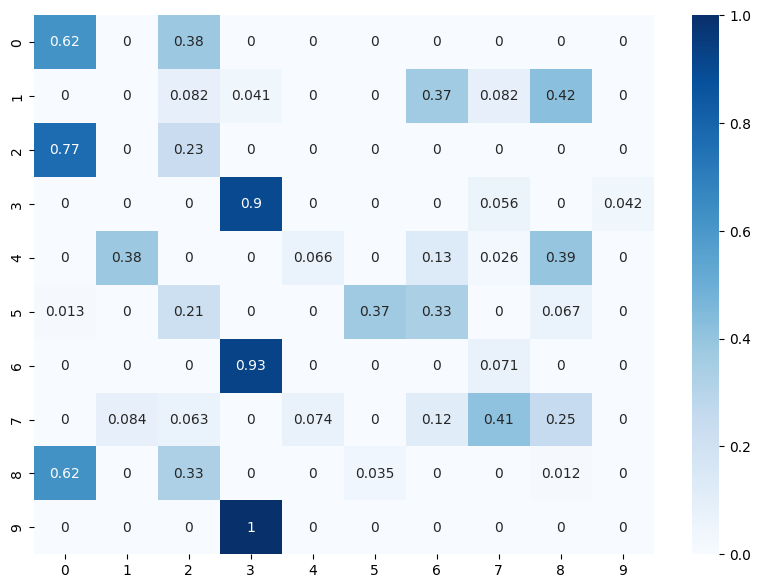

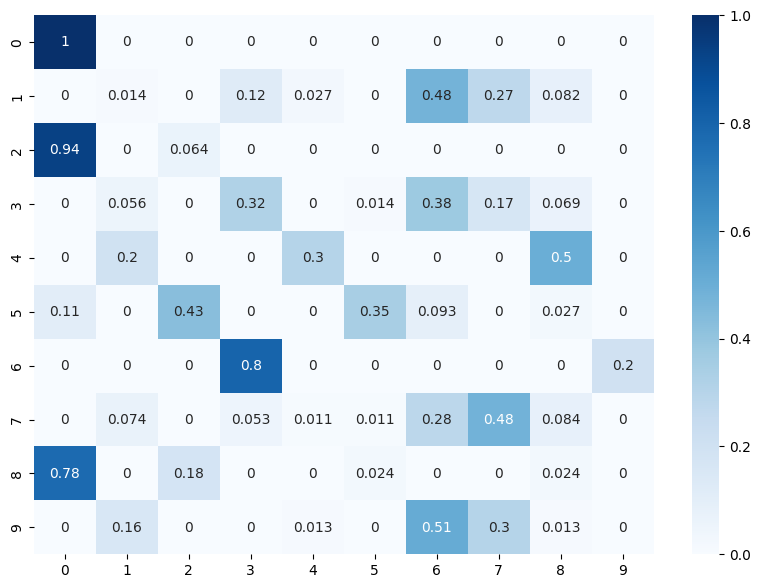

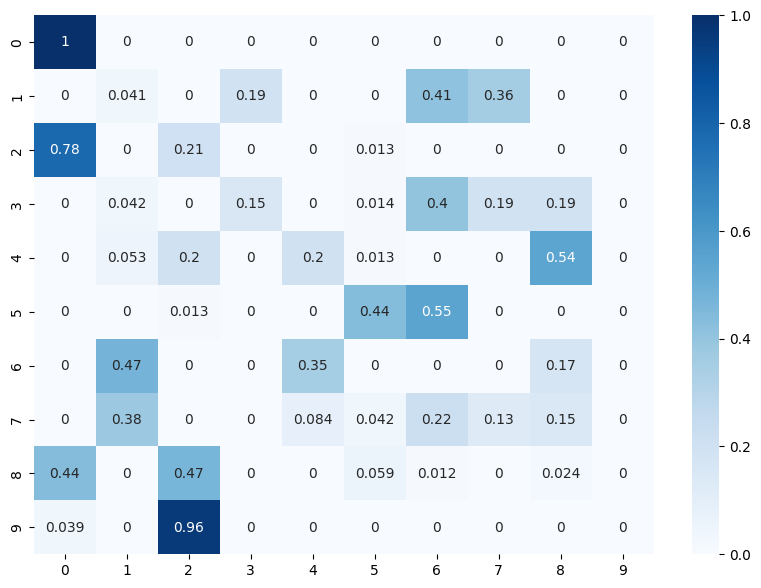

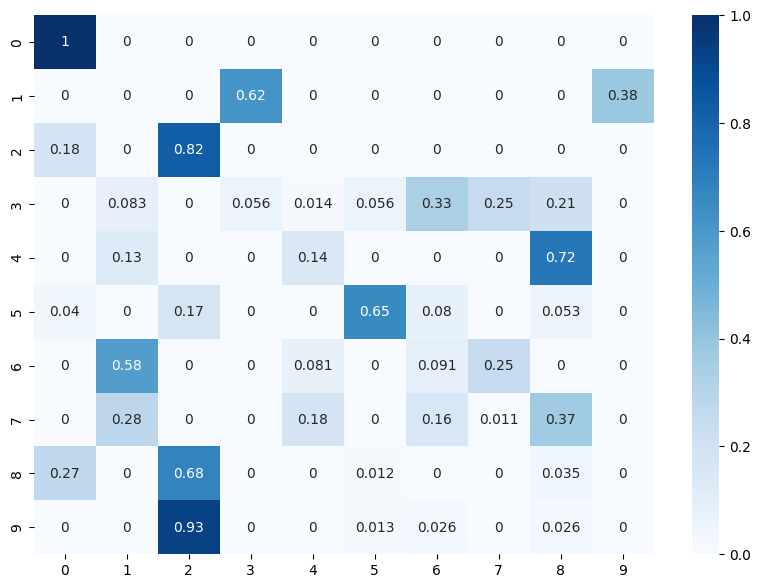

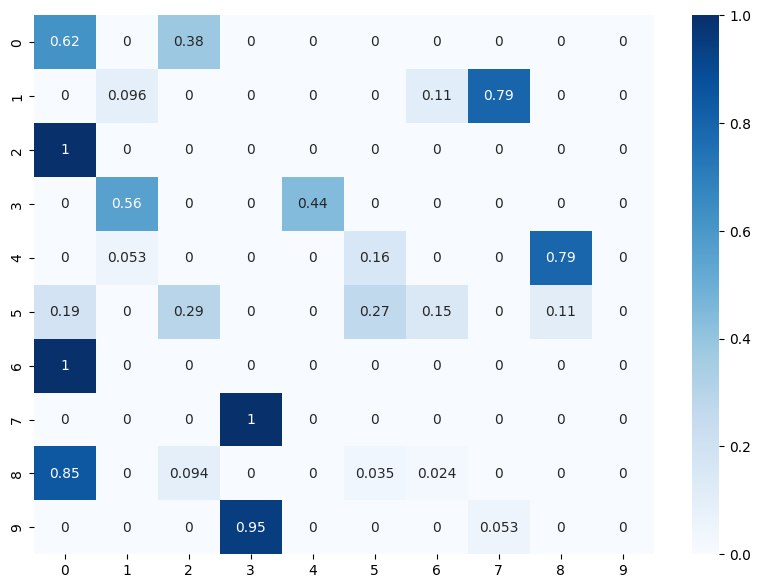

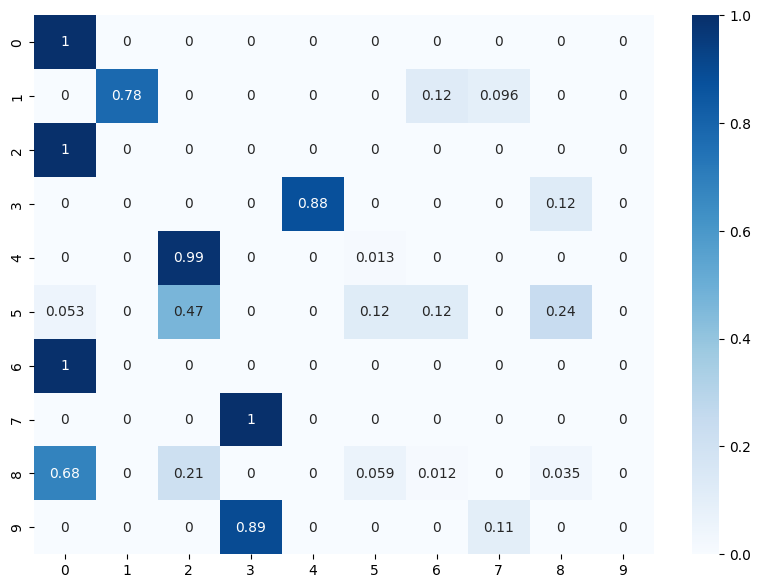

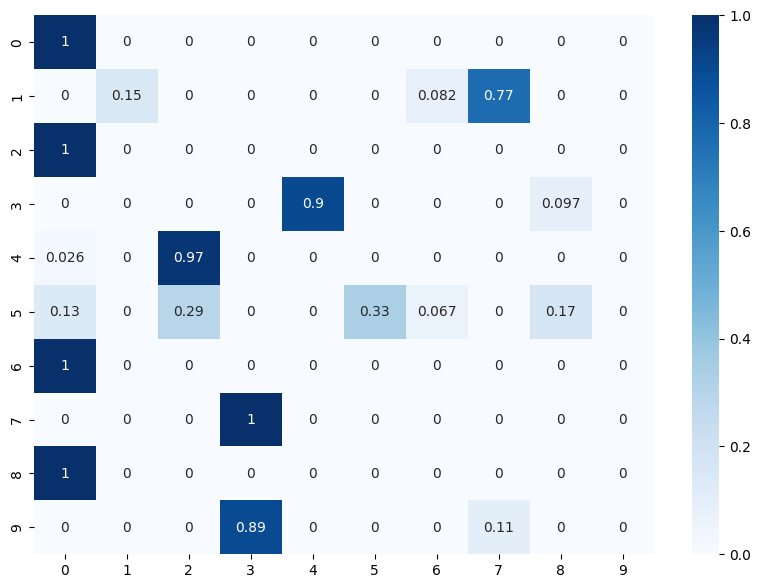

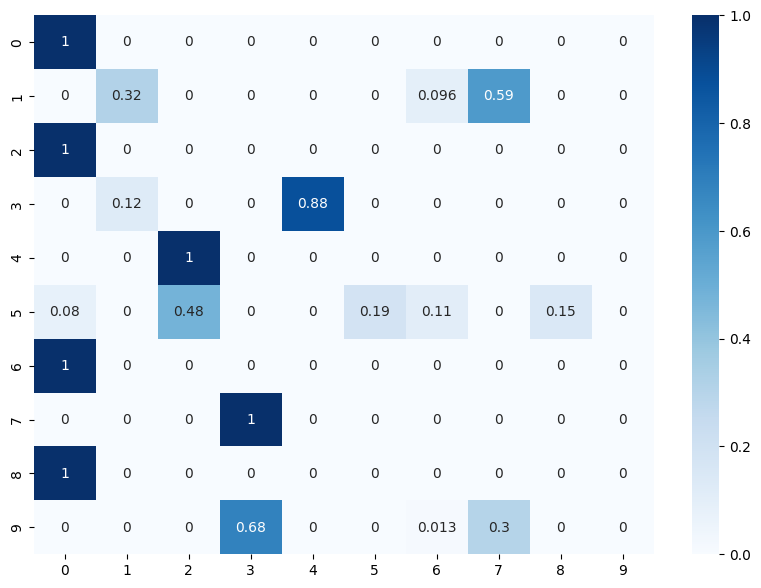

In [10]:
generate_confusion_matrix(encoder_tgt, classifier, test_dataloader_src, "cuda")
src_test_loss, src_test_acc = evaluate_src(encoder_tgt, classifier, phase='Test')
print(f'\t Test (with Source) Loss:{src_test_loss:0.2f} \t Test (with Source) Acc:{src_test_acc:0.2f}') 
for phase in range(len(target_domains)):
    if(phase == 0): # Domain A to B
        print(f'\nPhase {phase + 1} (Domain {source_domain} to Domain {target_domains[phase]})')
    else: # Domain B to C, and Domain C to D
        print(f'\nPhase {phase + 1} (Domain {target_domains[phase - 1]} to Domain {target_domains[phase]})')
    
    generate_confusion_matrix(encoder_tgt, classifier, test_dataloader_tgt[phase], "cuda")
    tgt_test_loss, tgt_test_acc = evaluate_tgt(encoder_tgt, classifier, test_dataloader_tgt[phase])
    print(f'\t Test (with Target) Loss:{tgt_test_loss:0.2f} \t Test (with Target) Acc:{tgt_test_acc:0.2f}') 